<a href="https://colab.research.google.com/github/lephuocdat2000/DeepLearning-and-Application/blob/main/SER/Eng_Vie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import scipy.io.wavfile
import numpy as np
import sys
import glob 
import librosa
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from IPython.display import Audio
### Time Distributed ConvNet imports ###
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, TimeDistributed, concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder
from IPython.display import Image
from glob import glob
import pickle
import itertools
from sklearn.model_selection import train_test_split
from PIL import Image

### Audioimport ###
import IPython

### Warning ###
import warnings
warnings.filterwarnings('ignore')

#Download dataset from Kaggle

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio")

#Extract signals and labels

In [ ]:
sample_rate = 16000     
max_pad_len = 49100
eng_signals = []
eng_labels = []
dataset_path = '/content/drive/MyDrive/Nhận dạng/ravdess-emotional-speech-audio'
actors = os.listdir(dataset_path)

for actor_file in actors:
    actor_path = os.path.join(dataset_path,actor_file)
    filenames = os.listdir(actor_path)
    for name in filenames:
        temp = int(name[6:8])
        if (temp==1) or (temp==3) or (temp==4) or (temp==5):
            if temp==1:  eng_labels.append(3)
            elif temp==3: eng_labels.append(1)
            elif temp==4: eng_labels.append(2)
            else: eng_labels.append(0)
            file_path = os.path.join(actor_path,name)
            y,sr = librosa.load(file_path, sr=sample_rate)
            y = zscore(y)
            if len(y) < max_pad_len:    
                y_padded = np.zeros(max_pad_len)
                y_padded[:len(y)] = y
                y = y_padded
            elif len(y) > max_pad_len:
                y = np.asarray(y[:max_pad_len])
            eng_signals.append(y)

eng_labels = np.array(eng_labels)
eng_signals = np.array(eng_signals)

#Augment noisy

In [ ]:
nb_augmented = 2

# Function to add noise to a signals with a desired Signal Noise ratio (SNR)
def noisy_signal(signal, snr_low=15, snr_high=30, nb_augmented=2):
    
    # Signal length
    signal_len = len(signal)

    # Generate White noise
    noise = np.random.normal(size=(nb_augmented, signal_len))
    
    # Compute signal and noise power
    s_power = np.sum((signal / (2.0 ** 15)) ** 2) / signal_len
    n_power = np.sum((noise / (2.0 ** 15)) ** 2, axis=1) / signal_len
    
    # Random SNR: Uniform [15, 30]
    snr = np.random.randint(snr_low, snr_high)
    
    # Compute K coeff for each noise
    K = np.sqrt((s_power / n_power) * 10 ** (- snr / 10))
    K = np.ones((signal_len, nb_augmented)) * K
    
    # Generate noisy signal
    return signal + K.T * noise


In [ ]:

print("Data Augmentation: START")
eng_augmented_signals = list(map(noisy_signal, eng_signals))
print("Data Augmentation: END!")

#Extract Mel

In [ ]:
def mel_spectrogram(y, sr=16000, n_fft=512, win_length=256, hop_length=128, window='hamming', n_mels=128, fmax=4000):
    
    # Compute spectogram
    mel_spect = np.abs(librosa.stft(y, n_fft=n_fft, window=window, win_length=win_length, hop_length=hop_length)) ** 2
    
    # Compute mel spectrogram
    mel_spect = librosa.feature.melspectrogram(S=mel_spect, sr=sr, n_mels=n_mels, fmax=fmax)
    
    # Compute log-mel spectrogram
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
    
    return mel_spect




In [ ]:
# Start feature extraction
print("Feature extraction: START")

# Compute spectogram for all audio file
eng_mel_spects = np.asarray(list(map(mel_spectrogram, eng_signals)))
eng_augmented_mel_spects = [np.asarray(list(map(mel_spectrogram, eng_augmented_signals[i]))) for i in range(len(eng_augmented_signals))]

# Stop feature extraction
print("Feature extraction: END!")

#Prepare Data

Training set

In [ ]:
# Build augmented labels and train
eng_aug_labels = np.asarray(list(itertools.chain.from_iterable([[label] * nb_augmented for label in eng_labels])))
eng_AUG_MEL_SPECTs = np.asarray(list(itertools.chain.from_iterable(eng_augmented_mel_spects)))
eng_X_train = np.concatenate((eng_mel_spects ,eng_AUG_MEL_SPECTs))
eng_y_train = np.concatenate((eng_labels,eng_aug_labels))

Test set

In [ ]:
from numpy import load

vie_X_test = load('/content/drive/MyDrive/Nhận dạng/vie-vie/vie_signals.npy')
vie_y_test = load('/content/drive/MyDrive/Nhận dạng/vie-vie/vie_labels.npy')
#Extract mel-spectrogram
vie_X_test = np.asarray(list(map(mel_spectrogram, vie_X_test)))
eng_X_train = load('eng-vie_X_train.npy')
eng_y_train = load('eng-vie_y_train.npy')

Split to frame

In [ ]:
#Time distributed parameters
win_ts = 128
hop_ts = 64

# Split spectrogram into frames
def frame(x, win_step=128, win_size=64):
    nb_frames = 1 + int((x.shape[2] - win_size) / win_step)
    frames = np.zeros((x.shape[0], nb_frames, x.shape[1], win_size)).astype(np.float32)
    for t in range(nb_frames):
        frames[:,t,:,:] = np.copy(x[:,:,(t * win_step):(t * win_step + win_size)]).astype(np.float32)
    return frames


In [ ]:

eng_X_train = frame(eng_X_train, hop_ts, win_ts)
vie_X_test = frame(vie_X_test, hop_ts, win_ts)

In [ ]:
from numpy import save 

save('eng-vie_X_train',eng_X_train)
save('eng-vie_y_train',eng_y_train) 

Label Encoding

In [ ]:
cd /content/drive/MyDrive/Nhận dạng/eng-vie

/content/drive/MyDrive/Nhận dạng/eng-vie


In [ ]:
#Encode label
lb = LabelEncoder()
eng_y_train = np_utils.to_categorical(lb.fit_transform(np.ravel(eng_y_train)))
vie_y_test = np_utils.to_categorical(lb.transform(np.ravel(vie_y_test)))

eng_X_train = eng_X_train.reshape(eng_X_train.shape[0], eng_X_train.shape[1] , eng_X_train.shape[2], eng_X_train.shape[3], 1)
vie_X_test = vie_X_test.reshape(vie_X_test.shape[0], vie_X_test.shape[1] , vie_X_test.shape[2], vie_X_test.shape[3], 1)

#Training

Define model

In [ ]:
from IPython.display import Image

K.clear_session()

# Define two sets of inputs: MFCC and FBANK
input_y = Input(shape=eng_X_train.shape[1:], name='Input_MELSPECT')

## First LFLB (local feature learning block)
y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_1_MELSPECT')(input_y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_1_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_1_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'), name='MaxPool_1_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_1_MELSPECT')(y)     

## Second LFLB (local feature learning block)
y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_2_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_2_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_2_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_2_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_2_MELSPECT')(y)

## Second LFLB (local feature learning block)
y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_3_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_3_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_3_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_3_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_3_MELSPECT')(y)

## Second LFLB (local feature learning block)
y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_4_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_4_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_4_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_4_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_4_MELSPECT')(y)  

## Flat
y = TimeDistributed(Flatten(), name='Flat_MELSPECT')(y)                      
                               
# Apply 2 LSTM layer and one FC
y = LSTM(256, return_sequences=False, dropout=0.2, name='LSTM_1')(y)
y = Dense(eng_y_train.shape[1], activation='softmax', name='FC')(y)

# Build final model
model = Model(inputs=input_y, outputs=y)

# Plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png')

Compile

In [4]:
cd /content/drive/MyDrive/Nhận dạng/eng-vie

/content/drive/MyDrive/Nhận dạng/eng-vie


In [ ]:
# Compile model
model.compile(optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.8), loss='categorical_crossentropy', metrics=['accuracy'])

# Save best model
best_model_save = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.h5', save_best_only=True, monitor='val_accuracy', mode='max')

# Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, verbose=1, mode='max')

# Fit model
history = model.fit(eng_X_train,eng_y_train, batch_size=64, epochs=200, validation_data=(vie_X_test, vie_y_test), callbacks=[early_stopping, best_model_save])

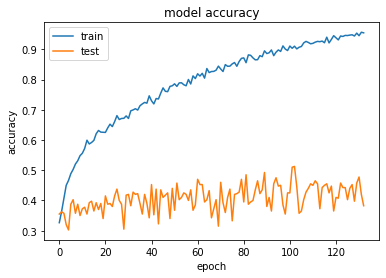

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


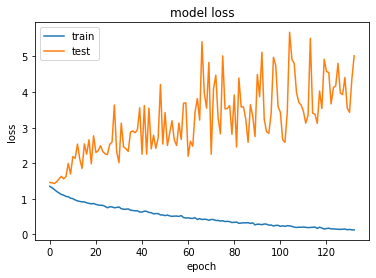

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [5]:
model = tf.keras.models.load_model('weights.103-2.59.h5')

In [7]:
max_pad_len = 49100

#Time distributed parameters
win_ts = 128
hop_ts = 64

# Split spectrogram into frames
def frame(x, win_step=128, win_size=64):
    nb_frames = 1 + int((x.shape[2] - win_size) / win_step)
    frames = np.zeros((x.shape[0], nb_frames, x.shape[1], win_size)).astype(np.float32)
    for t in range(nb_frames):
        frames[:,t,:,:] = np.copy(x[:,:,(t * win_step):(t * win_step + win_size)]).astype(np.float32)
    return frames

def mel_spectrogram(y, sr=16000, n_fft=512, win_length=256, hop_length=128, window='hamming', n_mels=128, fmax=4000):
    
    # Compute spectogram
    mel_spect = np.abs(librosa.stft(y, n_fft=n_fft, window=window, win_length=win_length, hop_length=hop_length)) ** 2
    
    # Compute mel spectrogram
    mel_spect = librosa.feature.melspectrogram(S=mel_spect, sr=sr, n_mels=n_mels, fmax=fmax)
    
    # Compute log-mel spectrogram
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
    
    return mel_spect
    
def predict_emotion_from_file(model, filename, chunk_step=16000, chunk_size=49100, predict_proba=False, sample_rate=16000):
        # Read audio file
        emotion1={0:'Angry',1:'Happy',2:'Sad',3:'Neutral'}
        y, sr = librosa.core.load(filename, sr=sample_rate, offset=0.5)
        win_ts = 128
        hop_ts = 64
        if len(y) < max_pad_len:    
          y_padded = np.zeros(max_pad_len)
          y_padded[:len(y)] = y
          y = y_padded
        elif len(y) > max_pad_len:
          y = np.asarray(y[:max_pad_len])
        # Split audio signals into chunks
        chunks = frame(y.reshape(1, 1, -1), chunk_step, chunk_size)
        # Reshape chunks
        chunks = chunks.reshape(chunks.shape[1],chunks.shape[-1])
        # Z-normalization
        y = np.asarray(list(map(zscore, chunks)))

        # Compute mel spectrogram
        mel_spect = np.asarray(list(map(mel_spectrogram, y)))

        # Time distributed Framing
        mel_spect_ts = frame(mel_spect,hop_ts,win_ts)
        # Build X for time distributed CNN
        X = mel_spect_ts.reshape(mel_spect_ts.shape[0],
                                    mel_spect_ts.shape[1],
                                    mel_spect_ts.shape[2],
                                    mel_spect_ts.shape[3],
                                    1)
        # Predict emotion
        if predict_proba is True:
            predict = model.predict(X)
        else:
            predict = np.argmax(model.predict(X), axis=1)
            predict = [emotion1.get(emotion) for emotion in predict]
        return predict
#Extract filename and label
data_path = '/content/drive/MyDrive/Nhận dạng/Data Voice/Test'
emotions=os.listdir(data_path)
true_labels = []
pred_labels = [] 
emotion1={0:'Angry',1:'Happy',2:'Sad',3:'Neutral'}

for emotion in emotions:
   emotion_path = os.path.join(data_path,emotion)
   file_names = os.listdir(emotion_path)
   for name in file_names:
      file_path = os.path.join(emotion_path,name)
      pred_labels.append(predict_emotion_from_file(model,file_path)[0])
      true_labels.append(emotion1.get(int(name[0])))

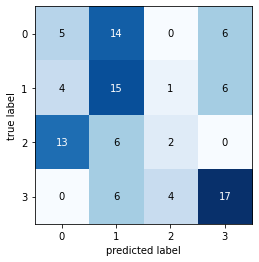

In [8]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_target=true_labels, 
                      y_predicted=pred_labels, 
                      binary=False)

fig, ax = plot_confusion_matrix(cm)
plt.show()

In [9]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score

f1_score(true_labels,pred_labels,average='macro')

0.3526317878691648